You may want to create an isolated conda environment for this: `conda create -n glove`. Activate that environment: `conda activate glove`. Then install whatever else you want in that environment, e.g.: `conda install -c conda-forge jupyterlab pandas scikit-learn gensim`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load in TR-by-TR action annotation from CSV
actions_df = pd.read_csv('visual_actions.csv', index_col=0)
agents_df = pd.read_csv('visual_agents.csv', index_col=0)
bg_df = pd.read_csv('visual_bg.csv', index_col=0)
actions_df

,0,1,2,3,4,5
0,splash,NaN,NaN,NaN,NaN,NaN
1,splash,NaN,NaN,NaN,NaN,NaN
2,splash,NaN,NaN,NaN,NaN,NaN
3,splash,NaN,NaN,NaN,NaN,NaN
4,splash,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1483,eating,biting,NaN,NaN,NaN,NaN
1484,eating,biting,NaN,NaN,NaN,NaN
1485,eating,biting,NaN,NaN,NaN,NaN
1486,eating,biting,NaN,NaN,NaN,NaN


In [3]:
# Convert actions per TR to a list in case that's useful
actions_list = [list(filter(lambda item: not pd.isnull(item), list(row)))
                for row in actions_df.iloc]
agents_list = [list(filter(lambda item: not pd.isnull(item), list(row)))
               for row in agents_df.iloc]
bg_list = [list(filter(lambda item: not pd.isnull(item), list(row)))
           for row in bg_df.iloc]

In [4]:
# Get unique words and remove NaN
actions_uniq = set(actions_df.values.ravel())
actions_uniq = [w for w in actions_uniq if not pd.isnull(w)]

agents_uniq = set(agents_df.values.ravel())
agents_uniq = [w for w in agents_uniq if not pd.isnull(w)]

bg_uniq = set(bg_df.values.ravel())
bg_uniq = [w for w in bg_uniq if not pd.isnull(w)]

In [5]:
# Let's sort the embeddings alphabetically for now
actions_uniq = sorted(actions_uniq)
agents_uniq = sorted(agents_uniq)
bg_uniq = sorted(bg_uniq)

In [6]:
# Download GloVe embedding dictionary (may take a minute)
glove = gensim.downloader.load('glove-wiki-gigaword-300')

In [7]:
# Extract GloVe embedding for a single word
example_emb = glove['swimming']
example_emb.shape

(300,)

In [8]:
# Fun exercise: look at most similar words
glove.most_similar('swimming')

[('swim', 0.6917363405227661),
 ('swimmers', 0.61309415102005),
 ('rowing', 0.6069017052650452),
 ('volleyball', 0.6009818911552429),
 ('pool', 0.6008366346359253),
 ('diving', 0.5916919708251953),
 ('gymnastics', 0.5819597244262695),
 ('indoor', 0.5628631114959717),
 ('championships', 0.5628427267074585),
 ('swimmer', 0.5612455010414124)]

In [9]:
# Get embeddings for all words
action_embs = []
for word in actions_uniq:
    action_embs.append(glove[word])
action_embs = np.stack(action_embs, 0)
print(action_embs.shape)

(95, 300)


In [10]:
from scipy.stats import zscore

# Compute word-by-word RDM from cosine distance between embeddings
action_rdm = pdist(zscore(action_embs, axis=0), metric='cosine')
print(f'vectorized RDM shape: {action_rdm.shape}')
print(f'square RDM shape: {squareform(action_rdm).shape}')

vectorized RDM shape: (4465,)
square RDM shape: (95, 95)


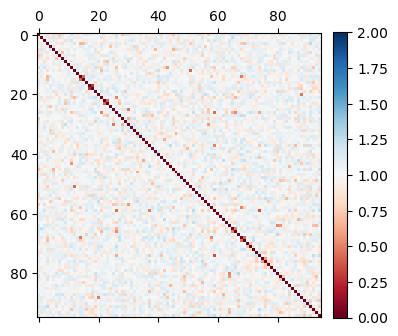

In [11]:
# Plot actions RDM
n_actions = action_embs.shape[0]

fig, ax = plt.subplots(figsize=(4, 4))
m = ax.matshow(squareform(action_rdm), cmap='RdBu',
               vmin=0, vmax=2)
fig.colorbar(m, fraction=0.046, pad=0.04);

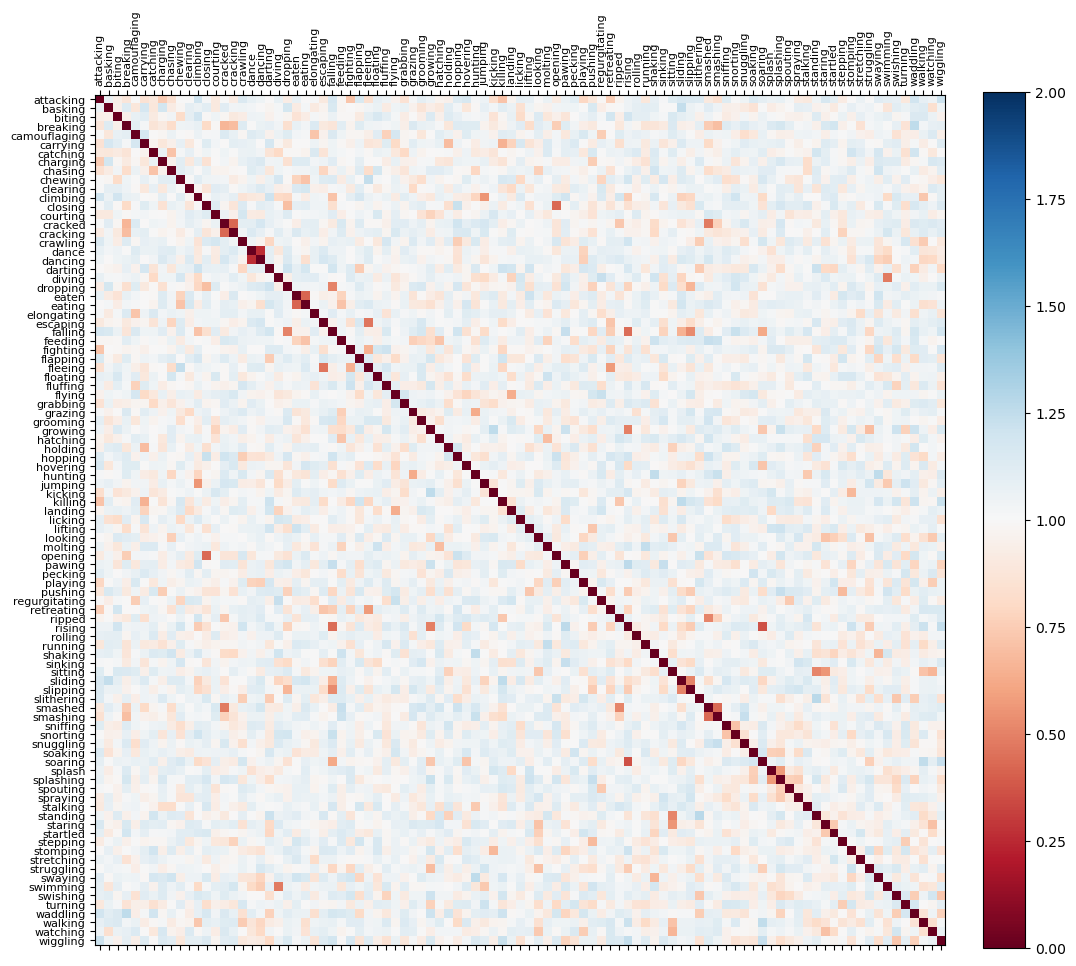

In [12]:
# The trick will be ordering and labeling words...
# Plot actions RDM
n_actions = action_embs.shape[0]

fig, ax = plt.subplots(figsize=(12, 12))
m = ax.matshow(squareform(action_rdm), cmap='RdBu',
               vmin=0, vmax=2)
ax.set_xticks(np.arange(n_actions), actions_uniq, rotation=90, size=8)
ax.set_yticks(np.arange(n_actions), actions_uniq, size=8)
fig.colorbar(m, fraction=0.046, pad=0.04);

In [13]:
# Run MDS on precomputed distance matrix
mds = MDS(metric=True, dissimilarity="precomputed")
pos = mds.fit_transform(squareform(action_rdm))
pos.shape

/Users/snastase/opt/miniconda3/envs/encling/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


(95, 2)

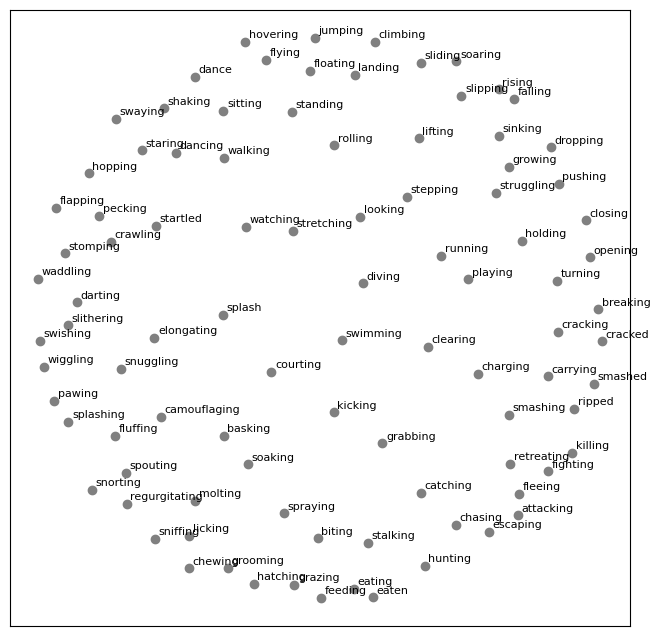

In [14]:
# Visualize positions returned by MDS
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], c='.5')
ax.set(xticks=[], yticks=[])
for x, y, w in zip(pos[:, 0], pos[:, 1], actions_uniq):
    ax.annotate(w, xy=(x + .01, y + .01), size=8)

In [15]:
# Try out non-metric MDS?
mds = MDS(metric=False, dissimilarity="precomputed")
pos = mds.fit_transform(squareform(action_rdm))
pos.shape

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/snastase/opt/miniconda3/envs/encling/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(95, 2)

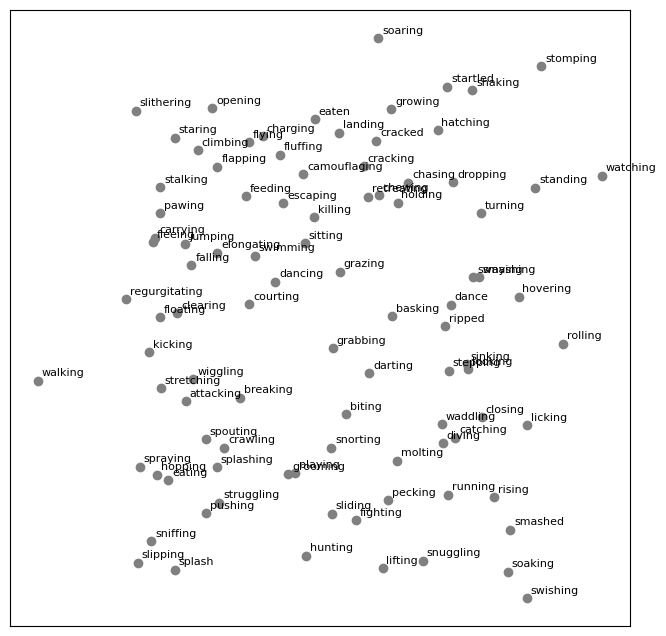

In [16]:
# Visualize positions returned by MDS
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], c='.5')
ax.set(xticks=[], yticks=[])
for x, y, w in zip(pos[:, 0], pos[:, 1], actions_uniq):
    ax.annotate(w, xy=(x + .01, y + .01), size=8)

(1488, 300)


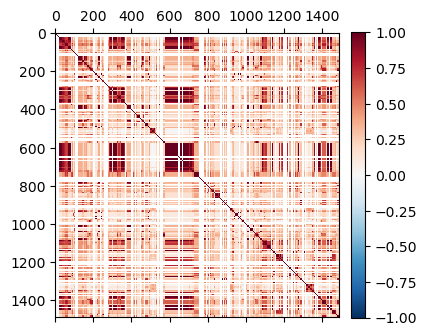

In [17]:
# Get embeddings for entire time series
n_dim, n_trs = 300, 1488
action_ts_embs = []
for words in actions_list:
    if len(words) == 0:
        action_ts_embs.append(np.zeros(n_dim))
    else:
        tr_embs = []
        for w in words:
            tr_embs.append(glove[w])
        action_ts_embs.append(np.mean(tr_embs, axis=0))
action_ts_embs = np.stack(action_ts_embs, axis=0)
print(action_ts_embs.shape)
action_ts_rdm = pdist(action_ts_embs, metric='correlation')
#action_ts_rdm = pdist(zscore(action_ts_embs, axis=0), metric='correlation')

fig, ax = plt.subplots(figsize=(4, 4))
m = ax.matshow(1 - squareform(action_ts_rdm), cmap='RdBu_r',
               vmin=-1, vmax=1)
fig.colorbar(m, fraction=0.046, pad=0.04);

(1488, 300)


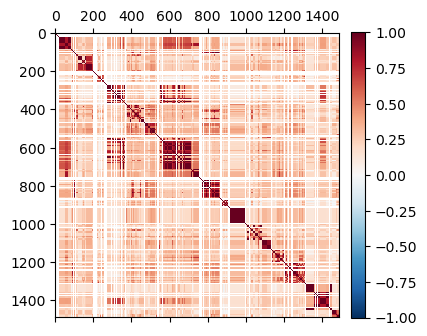

In [18]:
# Get embeddings for entire time series
n_dim, n_trs = 300, 1488
agent_ts_embs = []
for words in agents_list:
    if len(words) == 0:
        agent_ts_embs.append(np.zeros(n_dim))
    else:
        tr_embs = []
        for w in words:
            tr_embs.append(glove[w])
        agent_ts_embs.append(np.mean(tr_embs, axis=0))
agent_ts_embs = np.stack(agent_ts_embs, axis=0)
print(action_ts_embs.shape)
agent_ts_rdm = pdist(agent_ts_embs, metric='correlation')
#agent_ts_rdm = pdist(zscore(agent_ts_embs, axis=0), metric='correlation')

fig, ax = plt.subplots(figsize=(4, 4))
m = ax.matshow(1 - squareform(agent_ts_rdm), cmap='RdBu_r',
               vmin=-1, vmax=1)
fig.colorbar(m, fraction=0.046, pad=0.04);

(1488, 300)


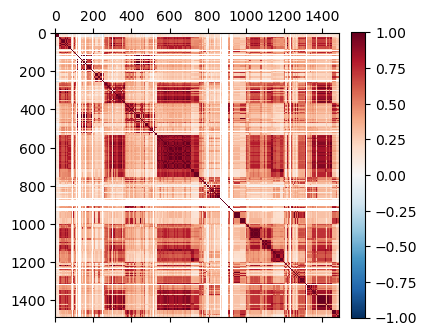

In [19]:
# Get embeddings for entire time series
n_dim, n_trs = 300, 1488
bg_ts_embs = []
for words in bg_list:
    if len(words) == 0:
        bg_ts_embs.append(np.zeros(n_dim))
    else:
        tr_embs = []
        for w in words:
            tr_embs.append(glove[w])
        bg_ts_embs.append(np.mean(tr_embs, axis=0))
bg_ts_embs = np.stack(bg_ts_embs, axis=0)
print(bg_ts_embs.shape)
bg_ts_rdm = pdist(bg_ts_embs, metric='correlation')
#bg_ts_rdm = pdist(zscore(bg_ts_embs, axis=0), metric='correlation')

fig, ax = plt.subplots(figsize=(4, 4))
m = ax.matshow(1 - squareform(bg_ts_rdm), cmap='RdBu_r',
               vmin=-1, vmax=1)
fig.colorbar(m, fraction=0.046, pad=0.04);

In [20]:
np.arange(0, n_trs, 200)

array([   0,  200,  400,  600,  800, 1000, 1200, 1400])

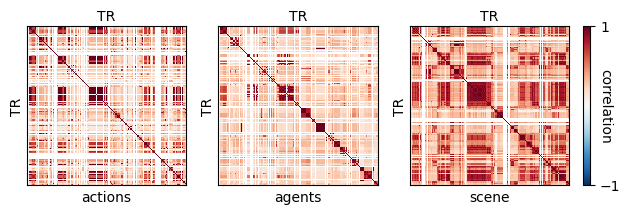

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(7, 2.3),
                        sharex=True, sharey=True)
rdms = [action_ts_rdm, agent_ts_rdm, bg_ts_rdm]
labels = ['actions', 'agents', 'scene']
for ax, rdm, label in zip(axs, rdms, labels):
    m = ax.matshow(1 - squareform(rdm),
                   cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set(xticks=[], yticks=[])
    ax.set_xlabel('TR', fontsize=10)
    ax.set_ylabel('TR', fontsize=10)
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad, ax.yaxis.labelpad = 4, 2
    ax.set_title(label, y=-.15, fontsize=10)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.69])
cbar = fig.colorbar(m, cax=cbar_ax, ticks=[-1, 1])
cbar.set_label('correlation', rotation=270, labelpad=-6)
plt.savefig('tsRDMs.svg', dpi=300, transparent=True, bbox_inches='tight')

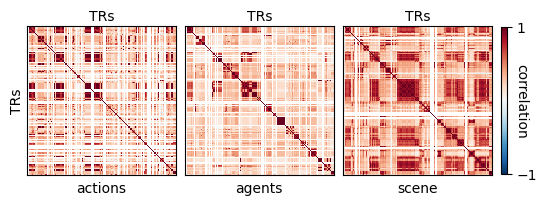

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2.3),
                        sharex=True, sharey=True)
rdms = [action_ts_rdm, agent_ts_rdm, bg_ts_rdm]
labels = ['actions', 'agents', 'scene']
for ax, rdm, label in zip(axs, rdms, labels):
    m = ax.matshow(1 - squareform(rdm),
                   cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set(xticks=[], yticks=[])
    ax.set_xlabel('TRs', fontsize=10)
    if label == 'actions':
        ax.set_ylabel('TRs', fontsize=10)
    ax.xaxis.set_label_position('top')
    ax.xaxis.labelpad, ax.yaxis.labelpad = 4, 2
    ax.set_title(label, y=-.17, fontsize=10)
plt.subplots_adjust(wspace=.06, hspace=0)
cbar_ax = fig.add_axes([0.915, 0.175, 0.01, 0.64])
cbar = fig.colorbar(m, cax=cbar_ax, ticks=[-1, 1])
cbar.set_label('correlation', rotation=270, labelpad=-6)
plt.savefig('tsRDMs.svg', dpi=300, transparent=True, bbox_inches='tight')

In [23]:
# Number of embeddings for each run in TRs
model_durs = {1: 369, 2: 341, 3: 372, 4: 406}

In [24]:
# Number of unique words per feature space
print(f'Unique action words: {len(actions_uniq)}')
print(f'Unique agent words: {len(agents_uniq)}')
print(f'Unique scene words: {len(bg_uniq)}')

Unique action words: 95
Unique agent words: 68
Unique scene words: 91


In [25]:
# Get number of words per TR
actions_n = (~actions_df.isnull()).sum(axis=1)
agents_n = (~agents_df.isnull()).sum(axis=1)
bg_n = (~bg_df.isnull()).sum(axis=1)
sum_n = np.sum((actions_n, agents_n, bg_n), axis=0)

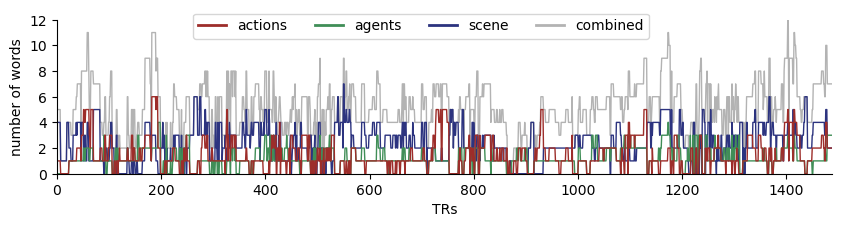

In [26]:
# Plot frequency of words per TR
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(sum_n, c='.7', lw=1, label='combined')
ax.plot(bg_n, c='#2C337F', lw=1, label='scene')
ax.plot(agents_n, c='#408E57', lw=1, label='agents')
ax.plot(actions_n, c='#9D2D2A', lw=1, label='actions')
ax.set(xlim=(0, len(sum_n)), ylim=(0, np.amax(sum_n)),
       xlabel='TRs', ylabel='number of words',
       yticks=(np.arange(0, 13, 2)))
handles, labels = ax.get_legend_handles_labels()
legend_order = [3, 2, 1, 0]
l = fig.legend([handles[i] for i in legend_order],
               [labels[i] for i in legend_order],
               loc='upper center', ncol=4,
               borderaxespad=1)
for line in l.get_lines():
    line.set_linewidth(2)
sns.despine()
plt.savefig('word_freq.svg', dpi=300, transparent=True, bbox_inches='tight')

In [27]:
# Load in action, agent, and scene embeddings
action_embs = np.load('visual_actions.npy')
agent_embs = np.load('visual_agents.npy')
bg_embs = np.load('visual_bg.npy')
moten_embs = np.load('visual_moten.npy')
assert len(action_embs) == len(agent_embs) == len(bg_embs) == len(moten_embs)
action_embs.shape

(1488, 300)

In [28]:
pca = PCA()
pca.fit(zscore(action_embs, axis=0))
actions_vaf = pca.explained_variance_ratio_
actions_90 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9) + 1
actions_95 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .95) + 1

pca = PCA()
pca.fit(zscore(agent_embs, axis=0))
agents_vaf = pca.explained_variance_ratio_
agents_90 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9) + 1
agents_95 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .95) + 1

pca = PCA()
pca.fit(zscore(bg_embs, axis=0))
bg_vaf = pca.explained_variance_ratio_
bg_90 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9) + 1
bg_95 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .95) + 1

pca = PCA()
pca.fit(zscore(moten_embs, axis=0))
moten_vaf = pca.explained_variance_ratio_
moten_90 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9) + 1
moten_95 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .95) + 1

comb_embs = np.hstack((action_embs, agent_embs, bg_embs))
pca = PCA()
pca.fit(zscore(comb_embs, axis=0))
comb_vaf = pca.explained_variance_ratio_
comb_90 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9) + 1
comb_95 = np.sum(np.cumsum(pca.explained_variance_ratio_) < .95) + 1

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [29]:
# Print out number of components to explain 90% variance
print(f'90% variance explained for actions: {actions_90} PCs')
print(f'90% variance explained for agents: {agents_90} PCs')
print(f'90% variance explained for bg: {bg_90} PCs')
print(f'90% variance explained for moten: {moten_90} PCs')
print(f'90% variance explained for combined (actions, agents, bg): {comb_90} PCs')

90% variance explained for actions: 28 PCs
90% variance explained for agents: 23 PCs
90% variance explained for bg: 24 PCs
90% variance explained for moten: 131 PCs
90% variance explained for combined (actions, agents, bg): 57 PCs


In [30]:
# Print out number of components to explain 90% variance WITH Z-SCORE
print(f'90% variance explained for actions: {actions_90} PCs')
print(f'90% variance explained for agents: {agents_90} PCs')
print(f'90% variance explained for bg: {bg_90} PCs')
print(f'90% variance explained for moten: {moten_90} PCs')
print(f'90% variance explained for combined (actions, agents, bg): {comb_90} PCs')

90% variance explained for actions: 28 PCs
90% variance explained for agents: 23 PCs
90% variance explained for bg: 24 PCs
90% variance explained for moten: 131 PCs
90% variance explained for combined (actions, agents, bg): 57 PCs


In [31]:
# Print out number of components to explain 95% variance
print(f'95% variance explained for actions: {actions_95} PCs')
print(f'95% variance explained for agents: {agents_95} PCs')
print(f'95% variance explained for bg: {bg_95} PCs')
print(f'95% variance explained for moten: {moten_95} PCs')
print(f'95% variance explained for combined (actions, agents, bg): {comb_95} PCs')

95% variance explained for actions: 38 PCs
95% variance explained for agents: 30 PCs
95% variance explained for bg: 32 PCs
95% variance explained for moten: 284 PCs
95% variance explained for combined (actions, agents, bg): 80 PCs


In [32]:
# Print out number of components to explain 95% variance WITH Z-SCORE
print(f'95% variance explained for actions: {actions_95} PCs')
print(f'95% variance explained for agents: {agents_95} PCs')
print(f'95% variance explained for bg: {bg_95} PCs')
print(f'95% variance explained for moten: {moten_95} PCs')
print(f'95% variance explained for combined (actions, agents, bg): {comb_95} PCs')

95% variance explained for actions: 38 PCs
95% variance explained for agents: 30 PCs
95% variance explained for bg: 32 PCs
95% variance explained for moten: 284 PCs
95% variance explained for combined (actions, agents, bg): 80 PCs


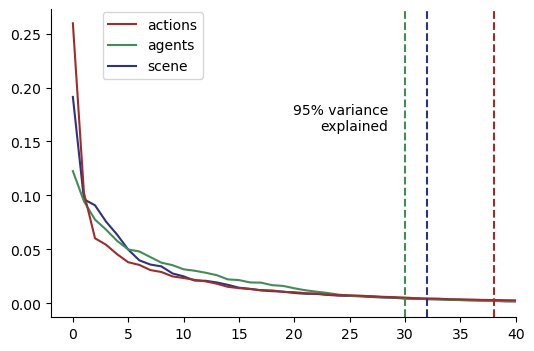

In [33]:
# Scree plot of variance explained
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bg_vaf, c='#2C337F', label='scene')
ax.plot(agents_vaf, c='#408E57', label='agents')
ax.plot(actions_vaf, c='#9D2D2A', label='actions')
ax.axvline(bg_95, c='#2C337F', ls='--')
ax.axvline(agents_95, c='#408E57', ls='--')
ax.axvline(actions_95, c='#9D2D2A', ls='--')
ax.set(xlim=(-2, 40))
handles, labels = ax.get_legend_handles_labels()
legend_order = [2, 1, 0]
l = fig.legend([handles[i] for i in legend_order],
               [labels[i] for i in legend_order],
               loc='upper left', bbox_to_anchor=(0.2, 0.89))
ax.annotate('95% variance\nexplained', xy=(28.5, .16), ha='right')
sns.despine()

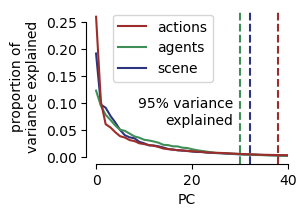

In [34]:
# Scree plot of variance explained
fig, ax = plt.subplots(figsize=(2.6, 2))
ax.plot(bg_vaf, c='#2C337F', label='scene')
ax.plot(agents_vaf, c='#408E57', label='agents')
ax.plot(actions_vaf, c='#9D2D2A', label='actions')
ax.axvline(bg_95, c='#2C337F', ls='--')
ax.axvline(agents_95, c='#408E57', ls='--')
ax.axvline(actions_95, c='#9D2D2A', ls='--')
ax.set(xlim=(-2, 40), xlabel='PC',
       ylabel='proportion of\nvariance explained')
ax.set_yticks(np.linspace(0, .25, 6))
handles, labels = ax.get_legend_handles_labels()
legend_order = [2, 1, 0]
l = fig.legend([handles[i] for i in legend_order],
               [labels[i] for i in legend_order],
               loc='upper left', bbox_to_anchor=(0.2, 0.89))
ax.annotate('95% variance\nexplained', xy=(28.5, .06), ha='right')
sns.despine(trim=True)
plt.savefig('scree_plot.svg', dpi=300, transparent=True, bbox_inches='tight')